# Image Classification using VGG16_BN 

In [1]:
# install dependencies and packages

!pip install torch torchvision scikit-learn cnn_finetune


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\krain\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# cnn_finetune imports caused problems, using torchvision directly instead
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
# prepare coral dataset

HEALTHY_IMAGES_DIR = "data/healthy_corals"
BLEACHED_IMAGES_DIR = "data/bleached_corals"

# imagepaths and labels
healthy_image_paths = [os.path.join(HEALTHY_IMAGES_DIR, img) for img in os.listdir(HEALTHY_IMAGES_DIR) if os.path.isfile(os.path.join(HEALTHY_IMAGES_DIR, img))]
bleached_image_paths = [os.path.join(BLEACHED_IMAGES_DIR, img) for img in os.listdir(BLEACHED_IMAGES_DIR) if os.path.isfile(os.path.join(BLEACHED_IMAGES_DIR, img))]

image_paths = healthy_image_paths + bleached_image_paths
labels = [0] * len(healthy_image_paths) + [1] * len(bleached_image_paths)

# split dataset into training (80%), validation (10%) and testing (10%)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)
val_paths, test_paths, val_labels, test_labels = train_test_split(temp_paths, temp_labels, test_size=0.5, random_state=42)

print('Dataset was successfully split into training, validation, and testing sets')


Dataset was successfully split into training, validation, and testing sets


In [4]:
# define data transformation

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
# create Dataset and DataLoader

class SimpleDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

In [6]:
# create Datasets

train_dataset = SimpleDataset(train_paths, train_labels, transform=data_transforms)
val_dataset = SimpleDataset(val_paths, val_labels, transform=data_transforms)
test_dataset = SimpleDataset(test_paths, test_labels, transform=data_transforms)

In [7]:
# create Dataloader for each Dataset

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [8]:
# create model and adapt it to coral Dataset

model = models.vgg16_bn(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)

C:\Users\krain\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\krain\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [10]:
# define loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
# train model

num_epochs = 30
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # average loss
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')
    
    # validate
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f'Validation Accuracy: {val_accuracy:.2f}%')

print('Training completed')


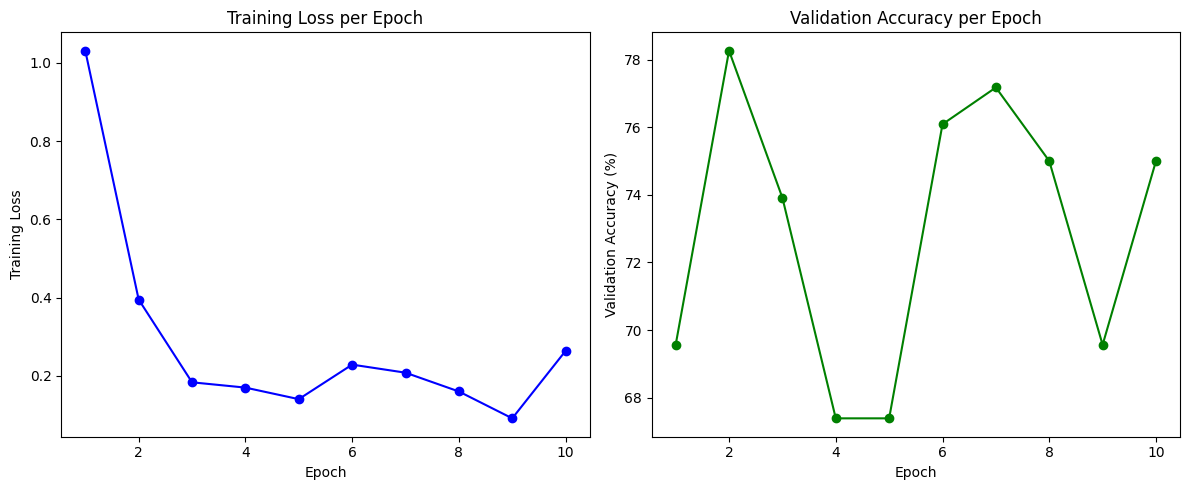

In [50]:
# visualize outcome
plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', color='b')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Epoch')

# plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, marker='o', color='g')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.title('Validation Accuracy per Epoch')

plt.tight_layout()
plt.show()